In [1]:
#mlp_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#9 July 2018
#
#train an mlp model on the XO dataset, this executes in about X minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate training and validation data
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
validate = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,-0.636452,-7.955052,7.980471,-1.650632,B,0.0,0.0,1.0
19996,19996,5.154912,-0.155150,5.157246,-0.030088,B,0.0,0.0,1.0
19997,19997,-2.757230,3.334301,4.326648,2.261743,B,0.0,0.0,1.0
19998,19998,-3.815203,6.136773,7.226048,2.127016,B,0.0,0.0,1.0
19999,19999,0.403370,3.186480,3.211909,1.444878,O,0.0,1.0,0.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

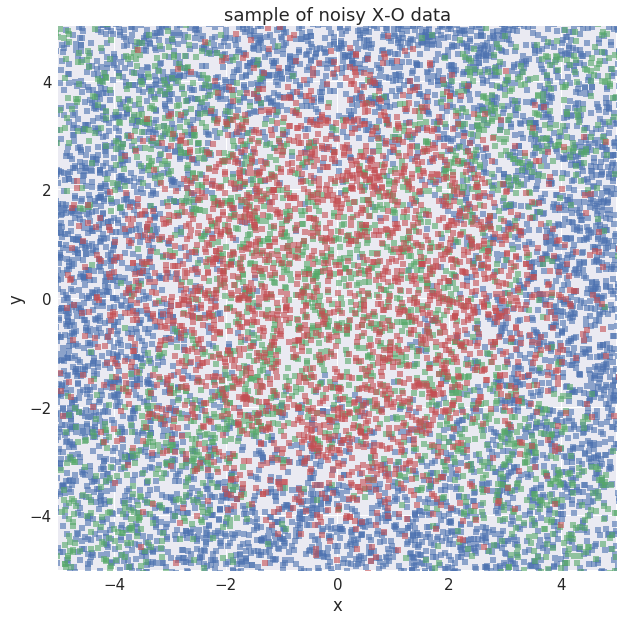

In [6]:
#scatterplot of noisy X-O data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/training_data.png')

In [7]:
#note class imbalance in training data
train.groupby('class')['id'].count()

class
B    14769
O     2530
X     2701
Name: id, dtype: int64

In [8]:
#rebalance training data & randomize records
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num')
print train_balanced.groupby('class')['id'].count()
train_balanced.head()

class
B    2530
O    2530
X    2701
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
6477,6477,0.521638,1.807607,1.881369,1.289850,X,1.0,0.0,0.0,0.000009
9706,9706,-0.668500,-1.433880,1.582057,-2.007055,O,0.0,1.0,0.0,0.000078
9878,9878,1.262693,3.006413,3.260815,1.173168,O,0.0,1.0,0.0,0.000224
3658,3658,-4.756659,1.658620,5.037542,2.806081,O,0.0,1.0,0.0,0.000510
6182,6182,4.536695,4.320039,6.264530,0.760941,X,1.0,0.0,0.0,0.000533


In [9]:
#rebalance validation data
df = validate
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
validate_balanced = df.sort_values('ran_num')
print validate_balanced.groupby('class')['id'].count()
validate_balanced.head()

class
B    2613
O    2613
X    2634
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
9509,9509,-0.778456,2.410044,2.532648,1.883223,X,1.0,0.0,0.0,0.000437
295,295,3.445499,-1.865068,3.917900,-0.496144,X,1.0,0.0,0.0,0.000524
1773,1773,-3.904276,-3.893999,5.514218,-2.357512,X,1.0,0.0,0.0,0.000638
19062,19062,-0.335783,-0.859443,0.922710,-1.943258,X,1.0,0.0,0.0,0.000721
9745,9745,-0.553827,1.992064,2.067618,1.841965,O,0.0,1.0,0.0,0.000727


In [10]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x_train = train_balanced[x_cols].values
y_train = train_balanced[y_cols].values
print x_train.shape, y_train.shape
x_val = validate_balanced[x_cols].values
y_val = validate_balanced[y_cols].values
print x_val.shape, y_val.shape

N_classes =  3
(7761, 2) (7761, 3)
(7860, 2) (7860, 3)


In [60]:
#this helper function assembles a simple MLP classifier
def mlp_classifier(layers, dropout_fraction=None):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation
    model = Sequential()
    #input layer
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    if (dropout_fraction):
        model.add(Dropout(dropout_fraction))
    #hidden layers
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
        if (dropout_fraction):
            model.add(Dropout(dropout_fraction))
    #output layer...see
    N = layers[-1]
    model.add(Dense(N, activation='linear'))
    #model.add(Dense(N, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [68]:
#build MLP classification model 
N_inputs = x_train.shape[1]
N_middle = 10*N_inputs*N_classes
N_outputs = N_classes
layers = [N_inputs, N_middle, N_outputs]
dropout_fraction = 0.0002
print 'layers = ', layers
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
model.summary()

layers =  [2, 60, 3]
dropout_fraction =  0.0002
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_35 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 60)                180       
_________________________________________________________________
dropout_36 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 183       
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [69]:
#fit model to the training data...takes a minute on m4.xl instance
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
N_training_epochs = 60
batch_size = 100
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_val, y_val), callbacks=[tensorboard])

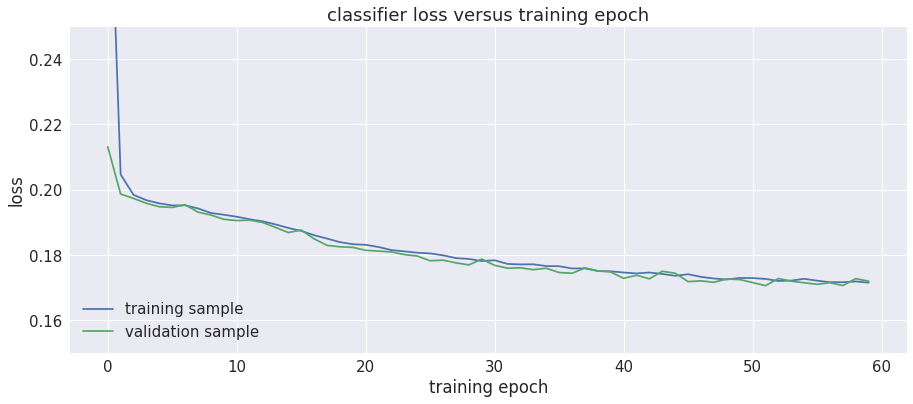

In [71]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
ax.set_ylim(0.15, 0.25)
plt.savefig('figs/mlp_loss.png')

In [109]:
#generate class predictions on another sample of X-O data
N_dots = 20000
xy = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = xy[x_cols].values
y = xy[y_cols].values
y_pred = model.predict(x)
#y_pred['y_sum'] = y_pred.O_score + y_pred.X_score + y_pred.B_score
#for y_col in y_cols:
#    y_pred[y_col] /= y_pred.y_sum
#y_pred['y_sum'] = y_pred.O_score + y_pred.X_score + y_pred.B_score
#idx = (y_pred.O_score > y_pred.X_score) & (y_pred.O_score > y_pred.B_score)
#y_pred.loc[idx, 'class_pred'] = 'O'
#idx = (y_pred.X_score > y_pred.B_score) & (y_pred.X_score > y_pred.O_score)
#y_pred.loc[idx, 'class_pred'] = 'X'
#idx = (y_pred.B_score > y_pred.O_score) & (y_pred.B_score > y_pred.X_score)
#y_pred.loc[idx, 'class_pred'] = 'B'
#y_pred.head()

AttributeError: 'DataFrame' object has no attribute 'x'

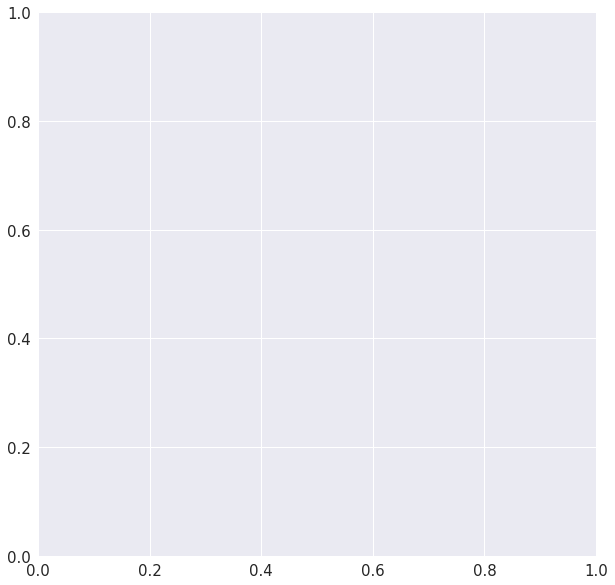

In [108]:
#scatterplot showing model's predicted decision boundaries
df = y_pred
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('SVM-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/mlp_decision_boundary.png')

In [ ]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0